In [31]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
import p5_util

import P7_DataBreed
oP7_DataBreed = p5_util.object_load('./data/oP7_DataBreed.dump')
oP7_DataBreed.show()
oP7_DataBreed.breed_show()


# Building a new model from pre-trained VGG16

`VGG16` is a CNN network provided by / implemented in `Keras` with 16 layers.

In [ ]:
from keras.applications.vgg16 import VGG16
import p5_util

vgg16_pretrained = VGG16() 

if False :
    filename = './data/vgg16_pretrained.dump'
    p5_util.object_dump(model,filename)

In [ ]:
type(vgg16_pretrained)

#### A breed and an image is selected and displayed

In [ ]:
oP7_DataBreed.breed_show()

In [ ]:
import P7_DataBreed

oP7_DataBreed.show_image_name('Mexican_hairless')

In [ ]:
import cv2

import p3_util
import p3_util_plot


import P7_DataBreed
import p7_util

breedname='Doberman'
imagename='n02107142_16400.jpg'
imagename='n02107142_4314.jpg'

oP7_DataBreed_single = P7_DataBreed.P7_DataBreed()
oP7_DataBreed_single._dict_breed_sample=oP7_DataBreed._dict_breed_sample.copy()

list_restricted_image = [(breedname,[imagename])]
oP7_DataBreed_single.list_restricted_image = list_restricted_image

oP7_DataBreed_single.load(dirbreed='n02107142-Doberman', imagename=imagename)

p7_util.p7_image_pil_show(oP7_DataBreed_single._dict_img_pil,std_image_size=(500,375), is_title=False)

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16


image_pathname = oP7_DataBreed._build_pathname(dirbreed,imagename)

# Charger l'image PIL
pil_image = load_img(image_pathname, target_size=(224, 224))  

# Convertir en tableau numpy
arr_image = img_to_array(pil_image)  

# Créer la collection d'images (un seul échantillon)
arr_image = img.reshape((1, arr_image.shape[0], arr_image.shape[1], arr_image.shape[2]))  
X_test = vgg16.preprocess_input(arr_image)  # Prétraiter l'image comme le veut VGG-16

y_pred = model.predict(X_test)


# Afficher les 3 classes les plus probables
[print(my_tuple) for my_tuple in vgg16.decode_predictions(y_pred, top=3)[0]]

oP7_DataBreed.breed_show()


In [ ]:
vgg16.decode_predictions(y_pred, top=3)[0]

In [ ]:
#print('Top 3 :', vgg16.decode_predictions(y_pred, top=3)[0])
print('Top 3 : {}'.format([my_tuple for my_tuple in vgg16.decode_predictions(y_pred, top=3)[0]]))

# Transfer Learning from `VGG16`

In [3]:
import p5_util

import P7_DataBreed
oP7_DataBreed = p5_util.object_load('./data/oP7_DataBreed.dump')
oP7_DataBreed.show()
oP7_DataBreed.breed_show()

p5_util.object_load : fileName= ./data/oP7_DataBreed.dump

 
Path to data directory ........ : ./data/Images
Number of original breeds ..... : 120
Total number of images ........ : 20580
Standard images size .......... : None
SIFT Image descriptors count .. : 0
Sampling : breeds count ....... : 3
Sampling : images per breed ... : 100
X train size .................. : 0
y train size .................. : 0
X test size ................... : 0
y test size ................... : 0
Clusters models  .............. : dict_keys([])
Current cluster model  ........ : 
Bag of features dataframe ..... : (0, 0)
Encoded labels from dataset ... : ()
Number of breeds in sample .... : 3
Image splitted ................ : False
Key point descriptors ......... : (128,)
Classifier name ............... : 
Supported classifiers ......... : []
Number of restricted images ... : 0
Splitted parts ................ : (3, 3)
Dataframe images descriptors .. : 0 / Index([], dtype='object')
KP filtering ................

In [4]:
nbreed = oP7_DataBreed.sampling_breed_count
nbreed

3

#### Download a VGG16 model that has been pre-trained with imageNet  : 
* last fully connected layers are removed; in the resulting model only convolutional layers stay.
* Image reshape is enforced to (224,224,3)

In [21]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
import p5_util
if False :
    # Load ImageNet pre-trained model from VGG-16 
    # Option include_top=False leads to remove last Fully connected layer.
    # VGG16 model is downloaed from network.
    #vgg16_pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    vgg16_pretrained_model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
    p5_util.object_dump(vgg16_pretrained_model,'./data/vgg16_pretrained_model.dump')
else :
    vgg16_pretrained_model = p5_util.object_load('./data/vgg16_pretrained_model.dump')
vgg16_pretrained_model.summary()

p5_util.object_load : fileName= ./data/vgg16_pretrained_model.dump
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_po

/home/bangui/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### An image is selected among breeds

In [ ]:
oP7_DataBreed.breed_show()

In [37]:
breedname='dingo'

In [38]:
oP7_DataBreed.show_image_name(breedname, is_sample_show=False)

Directory breed name = ./data/Images/n02115641-dingo

Number of images =56
Image name= n02115641_8474.jpg
Image name= n02115641_7181.jpg
Image name= n02115641_6309.jpg
Image name= n02115641_7237.jpg
Image name= n02115641_2953.jpg
Image name= n02115641_8150.jpg
Image name= n02115641_10561.jpg
Image name= n02115641_4851.jpg
Image name= n02115641_9065.jpg
Image name= n02115641_13295.jpg
Image name= n02115641_504.jpg
Image name= n02115641_7158.jpg
Image name= n02115641_12544.jpg
Image name= n02115641_5798.jpg
Image name= n02115641_9110.jpg
Image name= n02115641_8871.jpg
Image name= n02115641_11220.jpg
Image name= n02115641_1145.jpg
Image name= n02115641_630.jpg
Image name= n02115641_4262.jpg
Image name= n02115641_2424.jpg
Image name= n02115641_6509.jpg
Image name= n02115641_5687.jpg
Image name= n02115641_1574.jpg
Image name= n02115641_3110.jpg
Image name= n02115641_2701.jpg
Image name= n02115641_7549.jpg
Image name= n02115641_11668.jpg
Image name= n02115641_1228.jpg
Image name= n02115641_8

*** ERROR : image from path= ./data/Images/dingo/n02115641_4970.jpg NOT FOUND!


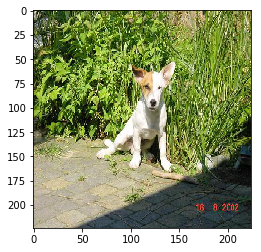

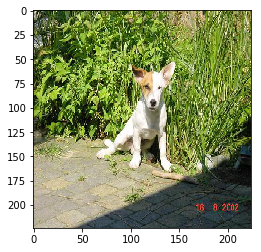

Original breed name = dingo / Greatest likehood breed name= dingo Prob=27.84


In [42]:
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import vgg16
import p7_util

imagename = 'n02115641_4970.jpg'
pil_image = oP7_DataBreed.read_image(breedname, imagename)

keras_image = p7_util.p7_pil_to_keras_image(pil_image, is_show=True)
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(keras_image.copy())
 
# get the predicted probabilities for each class
predictions = vgg16_pretrained_model.predict(processed_image)
# print predictions
 
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
pred_breedname_result = decode_predictions(predictions)
pred_breedname = pred_breedname_result[0][0][1]
pred_proba = pred_breedname_result[0][0][2]*100
print("Original breed name = "+breedname+" / Greatest likehood breed name= "+str(pred_breedname)+" Prob={0:0.2F}".format(pred_proba))

#### Transfer learning model is built
* Output of all layers previous top layer are extracted.
* A new fully connected layer (dense layer) is built using previous layer as an input layer

In [43]:
from keras import models
from keras import layers

# Outputs parameters are retrieved from previous layers
vgg16_model_tensor = vgg16_pretrained_model.output

# A new fully connected layer is then added in order to classify nbreeds breeds.
# Activation function is Softmax; This last layer is applied to the data input vgg16_model_parameters
vgg16_fc_tensor = layers.Dense(nbreed, activation='softmax')(vgg16_model_tensor)

# New VGG16 model for transfer learning is defined with : 
# * All layers except last layer are issued from 
# * fully connected layer previously defined.
model_vgg16_transfer_learning = models.Model(inputs=vgg16_pretrained_model.input, outputs=vgg16_fc_tensor)
type(model_vgg16_transfer_learning)

keras.engine.training.Model

#### Compilation : shape of all internal layers are computed by compiler

In [44]:
# Compiler le modèle 
from keras import optimizers

model_vgg16_transfer_learning.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [45]:
import numpy as np
import p5_util

filename='./data/arr_keras_X_y_train_test.dump'
(X_train,X_test, y_train, y_test) = p5_util.object_load(filename)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
if False :
    n_xtrain = int((X_train.shape[0]*X_train.shape[1]*X_train.shape[2]*X_train.shape[3])/(7*7*512))
    print(n_xtrain)

    n_ytrain = int((y_train.shape[0]*y_train.shape[1])/(7*7*512))
    print(n_ytrain)

    X_train = X_train.reshape((n_xtrain, 7, 7, 512))
    #y_train = y_train.reshape((n_ytrain, 7, 7, 512))
    print(X_train.shape, y_train.shape)
    np.unique(y_train)

p5_util.object_load : fileName= ./data/arr_keras_X_y_train_test.dump
(270, 224, 224, 3) (30, 224, 224, 3) (270, 1) (30, 1)


In [46]:
n_ytrain = int((y_train.shape[0]*y_train.shape[1])/(7*7*3))
print(n_ytrain)
y_train.shape,7*7*3

1


((270, 1), 147)

In [47]:
#help(model_vgg16_transfer_learning.fit)
model_vgg16_transfer_learning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [49]:
y_train.shape

(270, 1)

In [50]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model_vgg16_transfer_learning.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

ValueError: Error when checking target: expected dense_1 to have shape (3,) but got array with shape (1,)

## Total fine-tuning

On remplace la dernière couche fully-connected du réseau pré-entraîné par un classifieur adapté au nouveau problème (SVM, régression logistique...) et initialisé de manière aléatoire. Toutes les couches sont ensuite entraînées sur les nouvelles images. 

La stratégie #1 doit être utilisée lorsque la nouvelle collection d'images est grande : dans ce cas, on peut se permettre d'entraîner tout le réseau sans courir le risque d'overfitting. De plus, comme les paramètres de toutes les couches (sauf de la dernière) sont initialement ceux du réseau pré-entraîné, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait été aléatoire.